In [1]:
import copy
import shap
import pickle
import optuna
import numpy as np
import lightgbm as lgb
import optuna.integration
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from optuna.samplers import TPESampler, RandomSampler
from sklearn.metrics import r2_score, root_mean_squared_error

SEED = 1338

# File with the flux tube geometries (features):
in_filename = "20240601-01-assembleFluxTubeMatrix_normalizeMeanStdIndependentOfZ_withAndWithoutCvdrift_nz97_withCvdrift.pkl"
# File with the GX heat flux
out_filename = "20240601-01-103_gx_nfp4_production_gx_results.pkl"

with open(in_filename, "rb") as f:
    in_data = pickle.load(f)

with open(out_filename, "rb") as f:
    out_data = pickle.load(f)

X = in_data["matrix"]
heat_flux_averages = out_data["Q_avgs"]

In [2]:
in_data.keys()

dict_keys(['tube_files', 'nl', 'z_functions', 'scalars', 'n_features', 'n_quantities', 'n_tubes', 'matrix', 'means', 'standard_deviations'])

In [3]:
in_data["matrix"]

array([[ 0.02278433,  0.79329694,  0.47829241, ..., -0.85963928,
        -0.8744202 , -0.80227028],
       [ 1.87583922,  1.81435098,  0.96975006, ...,  0.95706323,
         0.87230722,  0.27335504],
       [ 0.43586769,  1.80462561,  1.59276536, ..., -0.4965529 ,
        -0.77648957, -0.89956508],
       ...,
       [ 0.13053565, -0.7773523 , -0.59668751, ..., -0.37490712,
        -0.62196128, -0.69224254],
       [-1.35382024, -0.85957927, -0.1629058 , ...,  2.14119896,
         2.06968399,  1.78776422],
       [-0.31146954, -0.13072943, -0.79157277, ...,  1.37519525,
         1.23457818,  0.48518993]])

In [4]:
out_data["Q_avgs"]

array([ 9.75939  ,  9.549901 , 11.110395 , ..., 16.632994 ,  7.2723794,
       16.234438 ], dtype=float32)

In [5]:
features = in_data["matrix"]
target = np.log(out_data["Q_avgs"])

train_x, valid_x, train_y, valid_y = train_test_split(features, target, test_size=0.2, random_state=SEED)

In [6]:
# Define the objective function
def objective(trial):

    dtrain = lgb.Dataset(train_x, label=train_y)
    dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

    param = {
        'objective': trial.suggest_categorical("objective", ["regression_l2", "regression_l1"]),
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "rf", "dart"]),
        'linear_tree': trial.suggest_categorical("linear_tree", [True, False]),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'num_iterations': trial.suggest_int('num_iterations', 100, 1000),
        'max_bin': trial.suggest_int("max_bin", 64, 1024),
        'seed': trial.suggest_categorical("seed", [SEED]),
    }

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'rmse')

    param_deep = copy.deepcopy(param)
    del param_deep["num_iterations"]
    gbm = lgb.train(param_deep, 
                    dtrain, 
                    num_boost_round=param["num_iterations"], 
                    valid_sets=[dvalid], 
                    callbacks=[pruning_callback])

    preds = gbm.predict(valid_x)
    r2 = r2_score(valid_y, preds)
    
    return -r2

# Create a study object and optimize the objective function

sampler = TPESampler(seed=SEED) # Make the sampler behave in a deterministic way.
#sampler = RandomSampler(seed=SEED)

#pruner = optuna.pruners.MedianPruner()
pruner = optuna.pruners.HyperbandPruner()

study = optuna.create_study(direction='minimize', pruner=pruner, sampler=sampler)
study.optimize(objective, n_trials=20000, timeout=7200) # run for 2 hours

# Display the best hyperparameters
print('Best hyperparameters: ', study.best_params)

[I 2024-06-13 14:20:09,527] A new study created in memory with name: no-name-8253d320-947f-441a-aee0-7e6645c23ec2
[I 2024-06-13 14:20:17,944] Trial 0 finished with value: 3.0651473363647908 and parameters: {'objective': 'regression_l1', 'boosting_type': 'rf', 'linear_tree': True, 'lambda_l1': 0.13301648951575726, 'lambda_l2': 0.0465439550799397, 'num_leaves': 280, 'feature_fraction': 0.20093617600437247, 'bagging_fraction': 0.1375258026425314, 'bagging_freq': 8, 'min_child_samples': 10, 'learning_rate': 1.3732916339377326e-05, 'max_depth': -1, 'min_split_gain': 0.48107219848487204, 'subsample': 0.8511670810894018, 'colsample_bytree': 0.2176504192291312, 'num_iterations': 620, 'max_bin': 703, 'seed': 1338}. Best is trial 0 with value: 3.0651473363647908.
[I 2024-06-13 14:20:18,930] Trial 1 finished with value: 4.280653427288993 and parameters: {'objective': 'regression_l1', 'boosting_type': 'dart', 'linear_tree': False, 'lambda_l1': 6.577034248096407e-08, 'lambda_l2': 4.475195467231305e

Best hyperparameters:  {'objective': 'regression_l2', 'boosting_type': 'gbdt', 'linear_tree': True, 'lambda_l1': 7.646724716569628e-08, 'lambda_l2': 1.1628288287984516, 'num_leaves': 172, 'feature_fraction': 0.14446333893334853, 'bagging_fraction': 0.9694704018889345, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.0376454335840857, 'max_depth': 28, 'min_split_gain': 0.14232664081571772, 'subsample': 0.7076405862385893, 'colsample_bytree': 0.4420944624129144, 'num_iterations': 873, 'max_bin': 372, 'seed': 1338}


In [7]:
study.best_params

{'objective': 'regression_l2',
 'boosting_type': 'gbdt',
 'linear_tree': True,
 'lambda_l1': 7.646724716569628e-08,
 'lambda_l2': 1.1628288287984516,
 'num_leaves': 172,
 'feature_fraction': 0.14446333893334853,
 'bagging_fraction': 0.9694704018889345,
 'bagging_freq': 1,
 'min_child_samples': 24,
 'learning_rate': 0.0376454335840857,
 'max_depth': 28,
 'min_split_gain': 0.14232664081571772,
 'subsample': 0.7076405862385893,
 'colsample_bytree': 0.4420944624129144,
 'num_iterations': 873,
 'max_bin': 372,
 'seed': 1338}

In [8]:
dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)    

gbm = lgb.train(study.best_params, dtrain, valid_sets=[dvalid])

/Users/goncaloabreu/repos/fusionchallenge/virtual/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9694704018889345, subsample=0.7076405862385893 will be ignored. Current value: bagging_fraction=0.9694704018889345
[LightGBM] [Warning] feature_fraction is set=0.14446333893334853, colsample_bytree=0.4420944624129144 will be ignored. Current value: feature_fraction=0.14446333893334853
[LightGBM] [Warning] bagging_fraction is set=0.9694704018889345, subsample=0.7076405862385893 will be ignored. Current value: bagging_fraction=0.9694704018889345
[LightGBM] [Warning] feature_fraction is set=0.14446333893334853, colsample_bytree=0.4420944624129144 will be ignored. Current value: feature_fraction=0.14446333893334853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252588
[LightGBM] [Info] Number of data points in the train set: 5196, number of used features: 679
[LightGBM] [Warning] bagging_fraction is se

In [9]:
preds = gbm.predict(valid_x)
rmse = root_mean_squared_error(valid_y, preds)
rmse

0.2978621756535022

Text(0.5, 1.0, 'Nonlinear GX turbulence calculations, linear regression using cvdrift: $R^2$ = 0.766')

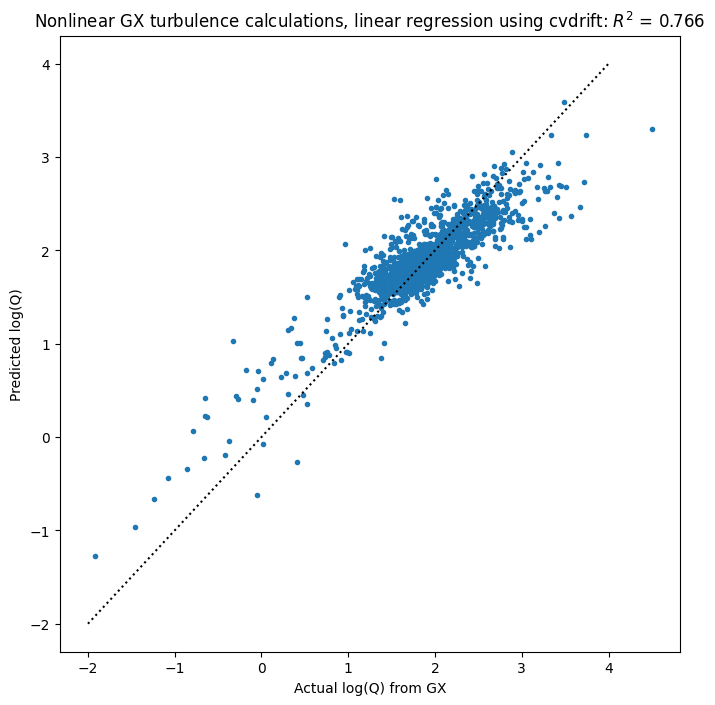

In [10]:
R2 = r2_score(valid_y, preds)

plt.figure(figsize=(8, 8))
plt.plot(valid_y, preds, '.')
plt.plot([-2, 4], [-2, 4], ':k')
plt.xlabel("Actual log(Q) from GX")
plt.ylabel("Predicted log(Q)")
plt.title(f"Nonlinear GX turbulence calculations, linear regression using cvdrift: $R^2$ = {R2:.3}")

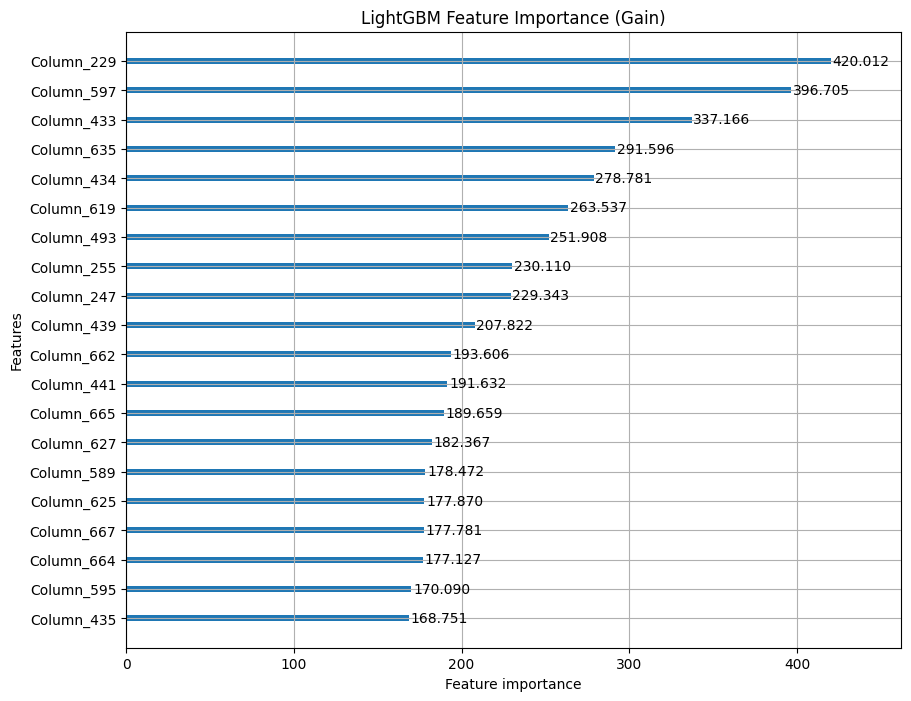

In [11]:
# Define the number of top features to plot
top_n_features = 20  # Change this value to display more or fewer features

# Plot feature importance using Gain
ax = lgb.plot_importance(gbm, importance_type="gain", max_num_features=top_n_features, figsize=(10, 8))
ax.set_title("LightGBM Feature Importance (Gain)")
plt.show()

In [13]:
if study.best_params["linear_tree"] == False:
    explainer = shap.TreeExplainer(gbm)
    shap_values = explainer(features)
    shap.summary_plot(shap_values, features, max_display=top_n_features)
else:
    print("SHAP does not work with linear trees")